In [6]:
import numpy as np

from Code.Tutorial.algo_ssa import SSA
from Code.Tutorial.Dataset import load_scg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [9]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope,distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [10]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features

In [37]:
if __name__ == '__main__':
    signals_train, labels_train, duration, fs = load_scg(0.8, 'train')
    signals_test, labels_test, _, _ = load_scg(0.8, 'test')
    signals_clean, _, _, _ = load_scg(0, 'train')
    S_train, D_train = labels_train[:, -2], labels_train[:, -1]
    S_test, D_test = labels_test[:, -2], labels_test[:, -1]

    features_train_np = np.load('../../Data/SSA/features_train_0.8_5000.npz.npy')
    features_test_np = np.load('../../Data/SSA/features_test_0.8_3000.npz.npy')
    idx_train = np.load('../../Data/SSA/idx_train_0.8_5000.npz.npy')
    idx_test = np.load('../../Data/SSA/idx_test_0.8_3000.npz.npy')

    L = 100
    trend2period = 10

    signals_train_idxed = signals_train[idx_train]
    labels_train_idxed = labels_train[idx_train]

    signals_test_idxed = signals_test[idx_test]
    labels_test_idxed = labels_test[idx_test]
    signals_clean_idxed = signals_train[idx_train]
    S_train_idxed = S_train[idx_train]
    D_train_idxed = D_train[idx_train]
    S_test_idxed = S_test[idx_test]
    D_test_idxed = D_test[idx_test]
    HR_train_idxed = labels_train[idx_train, 2]
    HR_test_idxed = labels_test[idx_test, 2]
    print(HR_test_idxed.shape, HR_test_idxed)

(2812,) [ 67. 122. 147. ...  91.  68.  95.]


In [54]:
def segmentation(signal, rpeak, h, d):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    template = np.median(pieces_padded, 0)

    # template_peaks_ = get_peaks(template, distance, duration, fs)
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        return None

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    # plt.plot(template)
    # plt.scatter(template_peaks, template[template_peaks])
    # plt.show()
    return [dis12/dis21, A0/A1]

def features(signals, L, trend2period, distance, HR_idxed, h, d):

    emp_features = []
    template_features = []
    idxs = []
    for i in tqdm(range(len(signals))):
        signal = signals[i]
        ssa_ = SSA(signal, L)
        signal_emp = ssa_.reconstruct(slice(trend2period, L))

        peaks_emp = get_peaks(signal_emp, distance, duration, fs)
        features_emp = get_features(signal_emp, peaks_emp)

        emp_S = features_emp[3]
        emp_D = features_emp[-1]

        large_peaks, _ = find_peaks(signal_emp, height=np.max(signal_emp) * 0.3, distance=int(6000//(HR_idxed[i]+2)))
        # plt.plot(signal_emp)
        # plt.scatter(large_peaks, signal_emp[large_peaks])
        # plt.show()
        template_feature = segmentation(signal_emp, large_peaks, h, d)

        if template_feature is not None:
            idxs.append(i)

            emp_features.append([emp_S, emp_D])
            template_features.append(template_feature)

        if i > 300:
            break
    return emp_features, template_features, idxs

L = 100
trend2period = 10

# 0.1, 0.2
emp_features_train, template_features_train, idxs_train = features(signals_train_idxed, L, trend2period, 10, HR_train_idxed, 0.1, 0.2)

# test 0.15, 0.25
emp_features_test, template_features_test, idxs_test = features(signals_test_idxed, L, trend2period, 15, HR_test_idxed, 0.15, 0.25)


 11%|█         | 301/2812 [04:02<33:39,  1.24it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


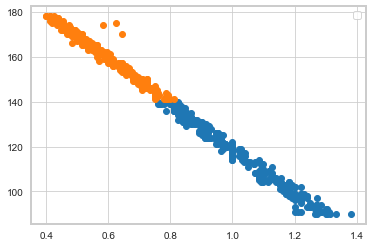

In [56]:
np.array(emp_features_train)
np.array(template_features_train)
np.array(emp_features_test)
np.array(template_features_test)


# D_train_idxed[idxs_train]

# D_test_idxed[idx_test]

plt.figure()
# plt.scatter(X, y, label='')
# plt.scatter(X, y, label='', marker='x')
plt.scatter(np.array(template_features_train)[:, 0], S_train_idxed[idxs_train], label='')
plt.scatter(np.array(template_features_test)[:, 0], S_test_idxed[idxs_test], label='')

# plt.scatter(np.array(emp_features_train)[:, 0], S_train_idxed[idxs_train], marker='x')
# plt.scatter(np.array(emp_features_test)[:, 0], S_test_idxed[idxs_test], marker='x')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


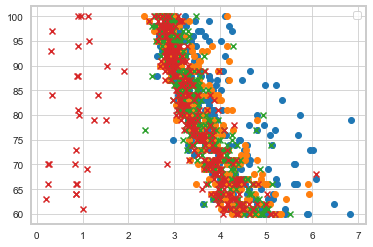

In [59]:
plt.figure()
# plt.scatter(X, y, label='')
# plt.scatter(X, y, label='', marker='x')
plt.scatter(np.array(template_features_train)[:, 1], D_train_idxed[idxs_train], label='')
plt.scatter(np.array(template_features_test)[:, 1], D_test_idxed[idxs_test], label='')

plt.scatter(np.array(emp_features_train)[:, 1], D_train_idxed[idxs_train], marker='x')
plt.scatter(np.array(emp_features_test)[:, 1], D_test_idxed[idxs_test], marker='x')

plt.legend()
plt.show()

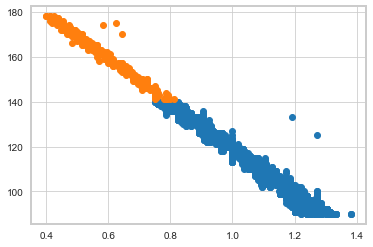

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


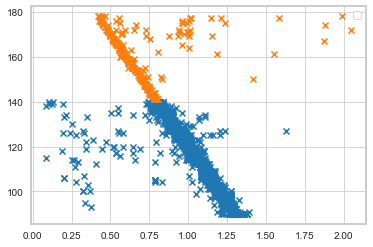

In [64]:
emp_features_train = np.load('../../Data/SSA/template/features_train_0.8_5000_NoRR_emp.npy')
template_features_train = np.load('../../Data/SSA/template/features_train_0.8_5000_NoRR_template.npy')
idxs_train = np.load('../../Data/SSA/template/idx_train_0.8_5000_NoRR_template.npy')

# D_train_idxed[idxs_train]

# D_test_idxed[idx_test]

plt.figure()
# plt.scatter(X, y, label='')
# plt.scatter(X, y, label='', marker='x')
plt.scatter(np.array(template_features_train)[:, 0], S_train_idxed[idxs_train], label='')
plt.scatter(np.array(template_features_test)[:, 0], S_test_idxed[idxs_test], label='')

plt.show()
plt.figure()

plt.scatter(np.array(emp_features_train)[:, 0], S_train_idxed[idxs_train], marker='x')
plt.scatter(np.array(emp_features_test)[:, 0], S_test_idxed[idxs_test], marker='x')

plt.legend()
plt.show()

In [75]:
X, y = features_train_np[:, 3].reshape(-1, 1), S_train[idx_train]
X_inacc, y_inacc = features_train_30_np[:, 3].reshape(-1, 1), S_train[idx_30_train_np]

plt.figure()
idx_start, idx_end = 0, 31
plt.scatter(X[31:], y[31:], label='train 31:')
plt.scatter(X[:31], y[:31], label='train :31', marker='x')
plt.scatter(X_inacc[idx_start: idx_end], y_inacc[idx_start: idx_end], label='inaccurate train :31')
plt.legend()
plt.show()

SyntaxError: invalid syntax (4288959118.py, line 1)

In [6]:
# X, y = features_train_np[:, 3].reshape(-1, 1), S_train[idx_train]
# X_test, y_test = features_test_np[:, 3], S_test[idx_test]
# X_acc, y_acc = features_train_30_np[:, 3].reshape(-1, 1), S_train[idx_30_train_np]
# X_test_acc, y_test_acc = features_test_30_np[:, 3].reshape(-1, 1), S_test[idx_30_test_np]
# plt.figure()
# idxex_start, idxex_end = 0, 8
# plt.scatter(X[31:], y[31:], label='train 31:')
# plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# plt.scatter(X_acc[idxex_start: idxex_end], y_acc[idxex_start: idxex_end], label='accurate train :31')
# # plt.scatter(X_test[31:], y_test[31:], label='test 31:')
# # 24(worse), 16(better)
# # idxes = 31
# # plt.scatter(X_test[:idxes], y_test[:idxes], label='test :31', marker='x')
# # plt.scatter(X_test_acc[:idxes], y_test_acc[:idxes], label='accurate test :31')
# plt.legend()
# plt.show()

In [7]:
# X, y = features_train_np[:, -1].reshape(-1, 1), D_train[idx_train]
# X_test, y_test = features_test_np[:, -1], D_test[idx_test]
# X_acc, y_acc = features_train_30_np[:, -1].reshape(-1, 1), D_train[idx_30_train_np]
# X_test_acc, y_test_acc = features_test_30_np[:, -1].reshape(-1, 1), D_test[idx_30_test_np]
# plt.figure()
# # plt.scatter(X[31:], y[31:], label='train 31:')
# # plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# # plt.scatter(X_acc, y_acc, label='accurate train :31')
# # plt.scatter(X_test[31:], y_test[31:], label='test 31:')
# plt.scatter(X_test[:31], y_test[:31], label='test :31', marker='x')
# plt.scatter(X_test_acc, y_test_acc, label='accurate test :31')
# plt.legend()
# # plt.show()

In [4]:
# from sklearn.linear_model import LinearRegression as LR
#
# reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
# yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
# np.mean(np.abs(yhat - S_test[idx_test]))
#
# from Code.Tutorial.utils import plot_2vectors
# plot_2vectors( S_test[idx_test], yhat, False, 'S_0.8')

In [2]:
# reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
# yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
# np.mean(np.abs(yhat - D_test[idx_test]))
#
# from Code.Tutorial.utils import plot_2vectors
# plot_2vectors( D_test[idx_test], yhat, False, 'D_0.8')